In [1]:
import numpy as np
import os
import sys

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display

from pipnet import data
from pipnet import model
from pipnet import utils

np.random.seed(1)

In [9]:
iso_pars = dict(
    td = 128,
    Fs = 3_200,
    nmin = 1,
    nmax = 5,
    freq_range = [500., 2700.],
    gmin = 1,
    gmax = 1,
    spread = 5.,
    lw_range = [[5e1, 2e2], [1e2, 5e2], [1e2, 1e3]],
    lw_probs = [0.6, 0.2, 0.2],
    int_range = [0.1, 1.], # Intensity
    norm_height = True,
    phase = 0.,
    debug = False,
)

mas_pars = dict(
    nw = 12,
    mas_w_range = [50_000., 100_000.],
    random_mas = True,
    mas_phase_p = 0.5,
    mas_phase_scale = 0.05,
    
    # First-order MAS-dependent parameters
    mas1_lw_range = [[1e7, 2e7], [1e7, 5e7], [5e7, 1e8]],
    mas1_lw_probs = [0.6, 0.3, 0.1],
    mas1_m_range = [[0., 0.], [0., 1e4], [1e4, 5e4]],
    mas1_m_probs = [0.2, 0.2, 0.6],
    mas1_s_range = [[-1e7, 1e7]],
    mas1_s_probs = [1.],

    # Second-order MAS-dependent parameters
    mas2_prob = 1.,
    mas2_lw_range = [[0., 0.], [1e11, 5e11]],
    mas2_lw_probs = [0.5, 0.5],
    mas2_m_range = [[0., 0.], [1e8, 5e8]],
    mas2_m_probs = [0.5, 0.5],
    mas2_s_range = [[0., 0.], [-2e10, 2e10]],
    mas2_s_probs = [0.5, 0.5],
    
    # Other MAS-dependent parameters
    non_mas_p = 0.5,
    non_mas_m_trends = ["constant", "increase", "decrease"],
    non_mas_m_probs = [0.34, 0.33, 0.33],
    non_mas_m_range = [0., 1.],
    
    int_decrease_p = 0.1,
    int_decrease_scale =[0.3, 0.7],
    debug = False,
)

data_pars = dict(
    iso_pars = iso_pars,
    mas_pars = mas_pars,
    
    positive_iso = True,
    encode_imag = False, # Encode the imaginary part of the MAS spectra
    encode_wr = True, # Encode the MAS rate of the spectra

    # noise parameters
    noise = 0., # Noise level
    mas_l_noise = 0.05,
    mas_s_noise = 25.,
    
    smooth_end_len = 10, # Smooth ends of spectra
    iso_spec_norm = 1.25, # Normalization factor for peaks
    mas_spec_norm = 0.5, # Normalization factor for MAS spectra
    wr_norm_factor = 100_000.,
    wr_inv = False, # Encode inverse of MAS rate instead of MAS rate
    gen_mas_shifts = False,
)

In [10]:
np.random.seed(1)
dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars)
Z, ws, iso = dataset.__getitem__(0)
print(torch.max(Z[:, 0]))
print(torch.max(iso))

tensor(0.8085)
tensor(0.7000)


In [11]:
n = 1000
mas_max = []
iso_max = []

for i in range(n):
    dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars)
    Z, ws, iso = dataset.__getitem__(0)
    mas_max.append(torch.max(Z[:, 0]))
    iso_max.append(torch.max(iso))

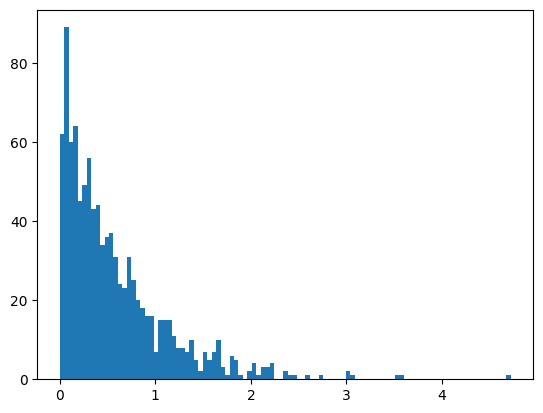

In [12]:
_ = plt.hist(mas_max, bins=101)

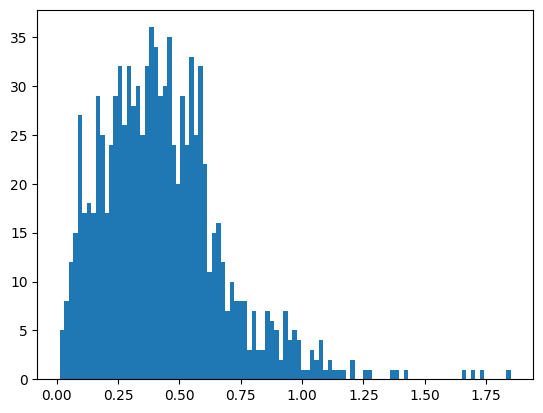

In [13]:
_ = plt.hist(iso_max, bins=101)

In [4]:
dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars, rot_prob=1.)

In [5]:
%%timeit
Z, ws, iso = dataset.__getitem__(0)

125 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars, rot_prob=0.)

In [7]:
%%timeit
Z, ws, iso = dataset.__getitem__(0)

34.8 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


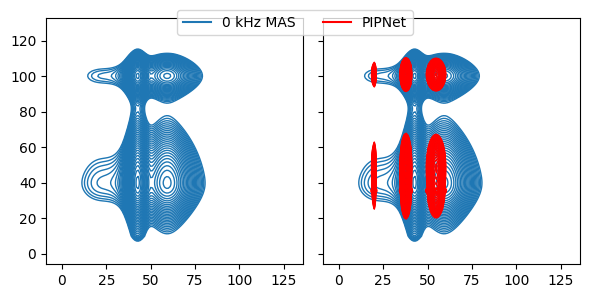

In [8]:
np.random.seed(1)
Z, ws, iso = dataset.__getitem__(0)

utils.plot_2d_iso_prediction(
    Z.numpy(),
    iso.numpy(),
)

In [4]:
import scipy.io
out_dir = "../../data/2D/sanity_check/"

In [5]:
np.random.seed(1)
dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars)

for i in range(64):
    
    Z, ws, iso = dataset.__getitem__(0)

    output = {}
    output["X"] = Z[:, 0].numpy()
    output["wr"] = ws
    output["iso"] = iso[0].numpy()
    
    utils.plot_2d_iso_prediction(
        Z.numpy(),
        iso.numpy(),
        xvals=dataset.xgen.f,
        yvals=dataset.ygen.f,
        wr_factor=dataset.xgen.norm_wr,
        show=False,
        save=f"{out_dir}generated_sample_{i+1}.pdf"
    )
    
    scipy.io.savemat(f"{out_dir}generated_sample_{i+1}.mat", output)
